In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import h5py
import copy
from skbeam.core.fitting.xrf_model import (ModelSpectrum,update_parameter_dict,
                                           set_parameter_bound,
                                           register_strategy)
from skbeam.core.fitting.background import snip_method
from pyxrf.model.guessparam import define_range
from pyxrf.model.fit_spectrum import extract_strategy

In [3]:
wd = '/Users/Li/Research/Experiment/tomo_hxn2016/'

In [4]:
# get parameter file
param_name = 'scan_7214_sum.json'
param_path = os.path.join(wd, param_name)
with open(param_path, 'r') as json_file:
    init_param = json.load(json_file)

param_dict = copy.deepcopy(init_param)

In [5]:
# get experimental data
exp_name = 'scan2D_7256.h5'
exp_path = os.path.join(wd, exp_name)
with h5py.File(exp_path) as f:
    data = f['xrfmap/detsum/counts'][:]

In [6]:
# show elements for fit
elist = param_dict['non_fitting_values']['element_list'].split(',')
elist = [e.strip() for e in elist]
elist

[u'Fe_K',
 u'Ga_K',
 u'Co_K',
 u'Gd_L',
 u'Cu_K',
 u'Pt_M',
 u'Pt_L',
 u'Userpeak1',
 u'Userpeak2',
 u'Ce_L',
 u'Au_M',
 u'Au_L']

In [7]:
# get x0 and y0 for fitting 
# define range
lowv = param_dict['non_fitting_values']['energy_bound_low']['value']
highv = param_dict['non_fitting_values']['energy_bound_high']['value']
print('low and high boundary is {} and {} in KeV'.format(lowv, highv))
y_sum = np.sum(data, axis=(0,1))
x0, y0 = define_range(y_sum, lowv, highv,
                      param_dict['e_offset']['value'],
                      param_dict['e_linear']['value'])

low and high boundary is 1.0 and 12.8 in KeV


In [8]:
# remove background first
bg = snip_method(y0,
                 param_dict['e_offset']['value'],
                 param_dict['e_linear']['value'],
                 param_dict['e_quadratic']['value'],
                 width=param_dict['non_fitting_values']['background_width'])

In [9]:
# basic function to perform fit
def fit_data(x, y, param_dict):
    elist = param_dict['non_fitting_values']['element_list'].split(',')
    elist = [e.strip() for e in elist]
    MS = ModelSpectrum(param_dict, elist)
    MS.assemble_models()
    c_weight = 1
    weights = 1/np.sqrt(c_weight + np.abs(y0))
    result = MS.model_fit(x0, y_for_fit,
                          weights=weights)
    return result

In [10]:
# set Co kb1 branching ratio as fitting parameter
param_dict['Co_kb1_ratio_adjust']['linear'] = 'lohi'


In [11]:
# remove background
y_for_fit = y0 - bg

In [12]:
# multiple fit
fit_strategy_list = ['fit_with_tail', 'linear']
for strat_name in fit_strategy_list:
    print(strat_name)
    strategy = extract_strategy(param_dict, strat_name)
    # register the strategy and extend the parameter list
    # to cover all given elements
    register_strategy(strat_name, strategy)
    set_parameter_bound(param_dict, strat_name)

    result = fit_data(x0, y_for_fit, param_dict)
    update_parameter_dict(param_dict, result)


fit_with_tail
linear


In [13]:
# add background back
fit_y = result.best_fit + bg

<IPython.core.display.Javascript object>


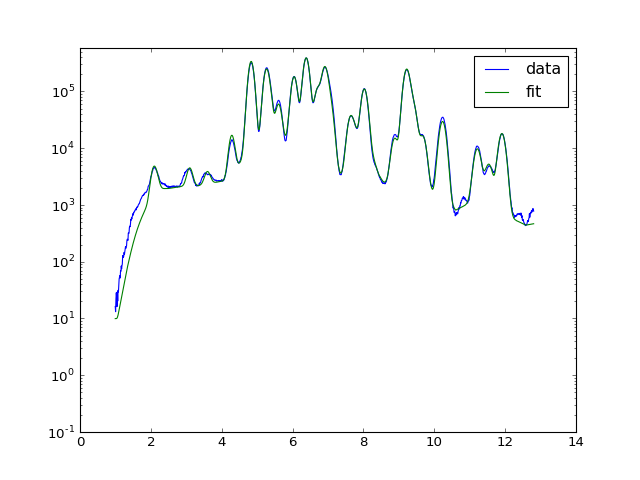

In [14]:
# view results
xv = result.best_values['e_offset'] + x0*result.best_values['e_linear']
fig, ax = plt.subplots()
ax.semilogy(xv, y0, '-', label='data')
ax.semilogy(xv, fit_y, label='fit')
ax.set_ylim([1e-1, 1.5*np.max(y0)])
plt.legend()

In [15]:
for v in result.params:
    if result.params[v].vary is True:
        print v

Fe_ka1_area
Co_ka1_area
Ga_ka1_area
Au_la1_area
Pt_ma1_area
Ce_la1_area
Co_kb1_ratio_adjust
Userpeak2_area
Gd_la1_area
elastic_coherent_sct_amplitude
Au_ma1_area
Pt_la1_area
Cu_ka1_area
Userpeak1_area
compton_amplitude


In [16]:
pname = 'Co_kb1_ratio_adjust'
print('initial value is {}'.format(result.init_params[pname]))
print('value after fit is {}'.format(result.params[pname]))
print('std of value after fit is {}'.format(result.params[pname].stderr))

initial value is <Parameter 'Co_kb1_ratio_adjust', 1.0, bounds=[0.1:5.0]>
value after fit is <Parameter 'Co_kb1_ratio_adjust', value=1.4137435634113393 +/- 0.0298, bounds=[0.1:5.0]>
std of value after fit is 0.0298391205727
